# Loading Image Data

So far we've been working with fairly artificial datasets that you wouldn't typically be using in real projects. Instead, you'll likely be dealing with full-sized images like you'd get from smart phone cameras. In this notebook, we'll look at how to load images and use them to train neural networks.

We'll be using a [dataset of cat and dog photos](https://www.kaggle.com/c/dogs-vs-cats) available from Kaggle. Here are a couple example images:

<img src='assets/dog_cat.png'>

We'll use this dataset to train a neural network that can differentiate between cats and dogs. These days it doesn't seem like a big accomplishment, but five years ago it was a serious challenge for computer vision systems.

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
from torchvision import datasets, transforms

import helper

The easiest way to load image data is with `datasets.ImageFolder` from `torchvision` ([documentation](http://pytorch.org/docs/master/torchvision/datasets.html#imagefolder)). In general you'll use `ImageFolder` like so:

```python
dataset = datasets.ImageFolder('path/to/data', transform=transform)
```

where `'path/to/data'` is the file path to the data directory and `transform` is a list of processing steps built with the [`transforms`](http://pytorch.org/docs/master/torchvision/transforms.html) module from `torchvision`. ImageFolder expects the files and directories to be constructed like so:
```
root/dog/xxx.png
root/dog/xxy.png
root/dog/xxz.png

root/cat/123.png
root/cat/nsdf3.png
root/cat/asd932_.png
```

where each class has its own directory (`cat` and `dog`) for the images. The images are then labeled with the class taken from the directory name. So here, the image `123.png` would be loaded with the class label `cat`. You can download the dataset already structured like this [from here](https://s3.amazonaws.com/content.udacity-data.com/nd089/Cat_Dog_data.zip). I've also split it into a training set and test set.

### Transforms

When you load in the data with `ImageFolder`, you'll need to define some transforms. For example, the images are different sizes but we'll need them to all be the same size for training. You can either resize them with `transforms.Resize()` or crop with `transforms.CenterCrop()`, `transforms.RandomResizedCrop()`, etc. We'll also need to convert the images to PyTorch tensors with `transforms.ToTensor()`. Typically you'll combine these transforms into a pipeline with `transforms.Compose()`, which accepts a list of transforms and runs them in sequence. It looks something like this to scale, then crop, then convert to a tensor:

```python
transform = transforms.Compose([transforms.Resize(255),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor()])

```

There are plenty of transforms available, I'll cover more in a bit and you can read through the [documentation](http://pytorch.org/docs/master/torchvision/transforms.html). 

### Data Loaders

With the `ImageFolder` loaded, you have to pass it to a [`DataLoader`](http://pytorch.org/docs/master/data.html#torch.utils.data.DataLoader). The `DataLoader` takes a dataset (such as you would get from `ImageFolder`) and returns batches of images and the corresponding labels. You can set various parameters like the batch size and if the data is shuffled after each epoch.

```python
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
```

Here `dataloader` is a [generator](https://jeffknupp.com/blog/2013/04/07/improve-your-python-yield-and-generators-explained/). To get data out of it, you need to loop through it or convert it to an iterator and call `next()`.

```python
# Looping through it, get a batch on each loop 
for images, labels in dataloader:
    pass

# Get one batch
images, labels = next(iter(dataloader))
```
 
>**Exercise:** Load images from the `Cat_Dog_data/train` folder, define a few transforms, then build the dataloader.

In [2]:
data_dir = 'Cat_Dog_data/train'

transform = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
])
dataset = datasets.ImageFolder(data_dir, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)

<Axes: >

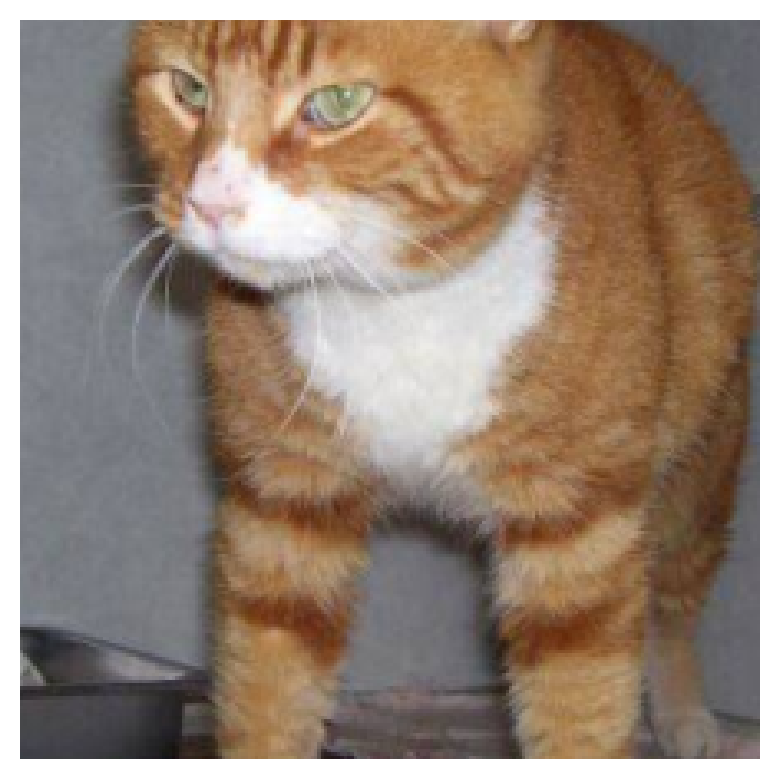

In [3]:
# Run this to test your data loader
images, labels = next(iter(dataloader))
helper.imshow(images[0], normalize=False)

If you loaded the data correctly, you should see something like this (your image will be different):

<img src='assets/cat_cropped.png' width=244>

## Data Augmentation

A common strategy for training neural networks is to introduce randomness in the input data itself. For example, you can randomly rotate, mirror, scale, and/or crop your images during training. This will help your network generalize as it's seeing the same images but in different locations, with different sizes, in different orientations, etc.

To randomly rotate, scale and crop, then flip your images you would define your transforms like this:

```python
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5, 0.5, 0.5], 
                                                            [0.5, 0.5, 0.5])])
```

You'll also typically want to normalize images with `transforms.Normalize`. You pass in a list of means and list of standard deviations, then the color channels are normalized like so

```input[channel] = (input[channel] - mean[channel]) / std[channel]```

Subtracting `mean` centers the data around zero and dividing by `std` squishes the values to be between -1 and 1. Normalizing helps keep the network work weights near zero which in turn makes backpropagation more stable. Without normalization, networks will tend to fail to learn.

You can find a list of all [the available transforms here](http://pytorch.org/docs/0.3.0/torchvision/transforms.html). When you're testing however, you'll want to use images that aren't altered (except you'll need to normalize the same way). So, for validation/test images, you'll typically just resize and crop.

>**Exercise:** Define transforms for training data and testing data below. Leave off normalization for now.

In [3]:
SIZE = 100  # 224

In [13]:
data_dir = './Cat_Dog_data'

train_transforms = transforms.Compose([
    transforms.RandomRotation(30),
    transforms.RandomResizedCrop(SIZE),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
    )
])

test_transforms = transforms.Compose([
    transforms.Resize(255),
    transforms.CenterCrop(SIZE),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225],
    )
])

# Pass transforms in here, then run the next cell to see how the transforms look
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
test_data = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

trainloader = torch.utils.data.DataLoader(train_data, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
tensor(1)
tensor(1)
tensor(1)


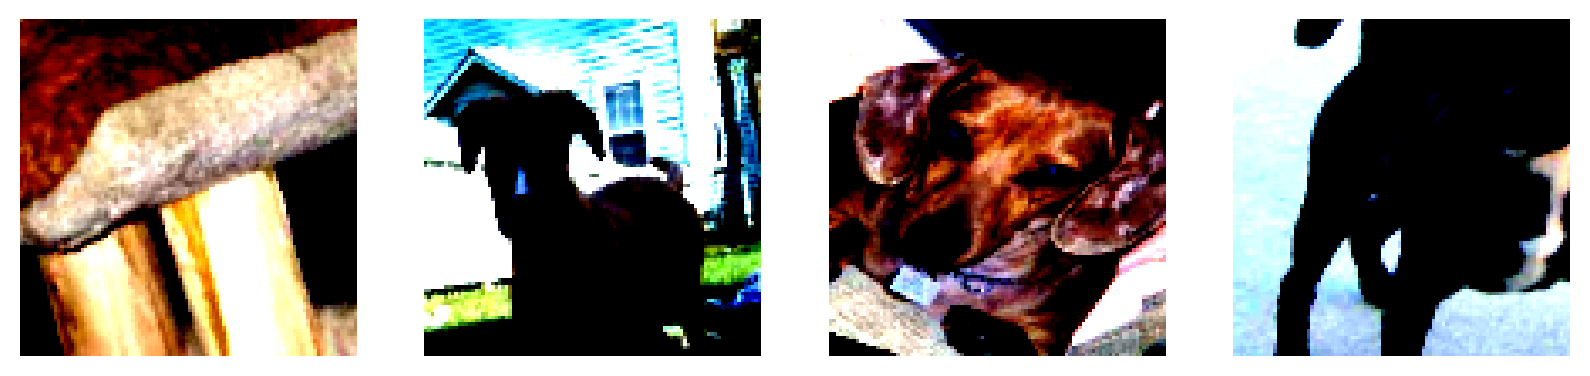

In [5]:
data_iter = iter(trainloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    print(labels[ii])
    ax = axes[ii]

    helper.imshow(images[ii], ax=ax, normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tensor(0)
tensor(0)
tensor(0)
tensor(0)


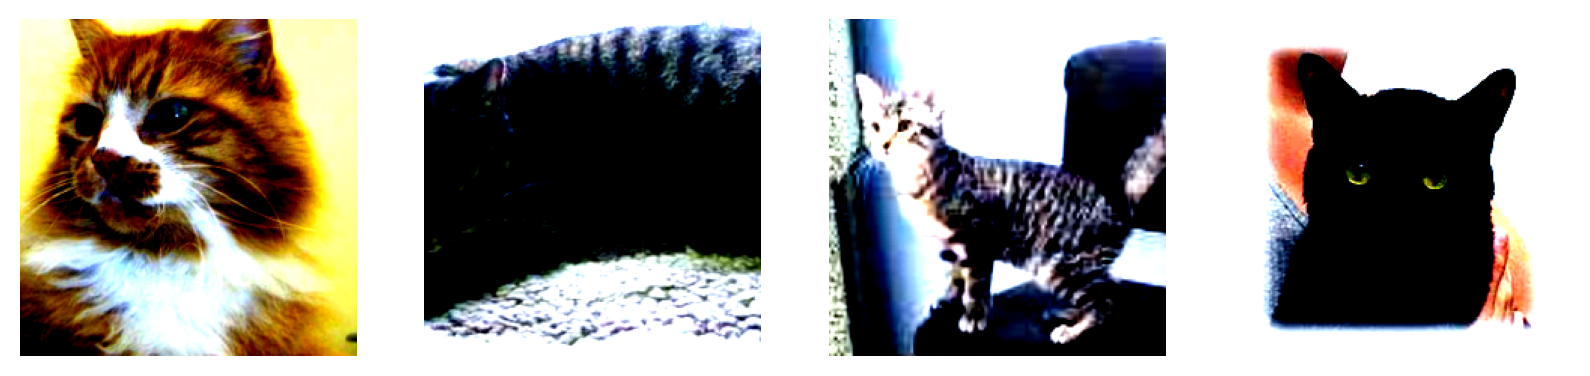

In [22]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)
    print(labels[ii])

Your transformed images should look something like this.

<center>Training examples:</center>
<img src='assets/train_examples.png' width=500px>

<center>Testing examples:</center>
<img src='assets/test_examples.png' width=500px>

At this point you should be able to load data for training and testing. Now, you should try building a network that can classify cats vs dogs. This is quite a bit more complicated than before with the MNIST and Fashion-MNIST datasets. To be honest, you probably won't get it to work with a fully-connected network, no matter how deep. These images have three color channels and at a higher resolution (so far you've seen 28x28 images which are tiny).

In the next part, I'll show you how to use a pre-trained network to build a model that can actually solve this problem.

In [8]:
from torch import nn, optim
import torch.nn.functional as F
SIZE = 224

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.hidden = nn.ModuleList(
            [nn.Linear(SIZE*SIZE*3, 2**12)] + 
            [
                nn.Linear(2**(i+1), 2**i)
                for i in range(11, 1, -1)
            ]
        )
        
        self.out = nn.Linear(4, 2)
        
        self.outf = nn.LogSoftmax(dim=1)
        self.d = nn.Dropout(p=0.20)
        
    def forward(self, x):
        # make sure input tensor is flattened
        x = x.view(x.shape[0], -1)
        
        for hidden in self.hidden:
            x = self.d(F.relu(hidden(x)))
            
        x = self.outf(self.out(x))
        
        return x


In [9]:
Classifier()

Classifier(
  (hidden): ModuleList(
    (0): Linear(in_features=150528, out_features=4096, bias=True)
    (1): Linear(in_features=4096, out_features=2048, bias=True)
    (2): Linear(in_features=2048, out_features=1024, bias=True)
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): Linear(in_features=256, out_features=128, bias=True)
    (6): Linear(in_features=128, out_features=64, bias=True)
    (7): Linear(in_features=64, out_features=32, bias=True)
    (8): Linear(in_features=32, out_features=16, bias=True)
    (9): Linear(in_features=16, out_features=8, bias=True)
    (10): Linear(in_features=8, out_features=4, bias=True)
  )
  (out): Linear(in_features=4, out_features=2, bias=True)
  (outf): LogSoftmax(dim=1)
  (d): Dropout(p=0.2, inplace=False)
)

In [6]:
def cuda(*args):
    if len(args) > 1:
        return [x.to('cuda') for x in args]
    else:
        return args[0].to('cuda')

In [7]:
from tqdm import tqdm
from collections.abc import Sized

class Cache(Sized):
    def __init__(self, data):
        self._data = data
        self.refresh()
        
    def refresh(self):
        self._loaded = list(self.load())
        
    def load(self):
        for images, labels in tqdm(self._data):
            yield images, labels
        
    def __iter__(self):
        return iter(self._loaded)
    
    def __len__(self):
        return len(self._loaded)


trainloader_cached = trainloader  # Cache(trainloader)

In [8]:
len(trainloader_cached)

352

In [22]:
from torch import nn
from torch import nn, optim
import torch.nn.functional as F

sizes = [
    SIZE*SIZE*3,
    1024,
    512,
    256,
    32,
    10,
]

pairs = [(int(sizes[i]), int(sizes[i+1])) for i in range(len(sizes) - 1)]
layers = sum(
    [
        [nn.Linear(p[0], p[1]), nn.ReLU()]
        for p in pairs
    ],
    []
) + [nn.Linear(10, 2), nn.LogSoftmax(dim=1)]
classifier = nn.Sequential(*layers)
classifier

Sequential(
  (0): Linear(in_features=30000, out_features=1024, bias=True)
  (1): ReLU()
  (2): Linear(in_features=1024, out_features=512, bias=True)
  (3): ReLU()
  (4): Linear(in_features=512, out_features=256, bias=True)
  (5): ReLU()
  (6): Linear(in_features=256, out_features=32, bias=True)
  (7): ReLU()
  (8): Linear(in_features=32, out_features=10, bias=True)
  (9): ReLU()
  (10): Linear(in_features=10, out_features=2, bias=True)
  (11): LogSoftmax(dim=1)
)

In [23]:
model = cuda(classifier)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
epochs_passed = 0

train_losses = []
test_losses = []
accs = []

In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

def draw():
    plt.plot(train_losses, label='Training loss')
    plt.plot(test_losses, label='Validation loss')
    plt.plot(torch.FloatTensor(accs)/100, label='Accuracy/100')
    plt.legend(frameon=False)


In [ ]:
from tqdm import tqdm

epochs = 20

for e in range(epochs):
    train_loss = 0
    model.train()
    
    for images, labels in tqdm(trainloader_cached):
        images, labels = cuda(images, labels)

        optimizer.zero_grad()
        
        log_ps = model(images.view(-1, SIZE*SIZE*3))
        loss = criterion(log_ps, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

    model.eval()
    with torch.no_grad():
        trues = 0
        total = 0
        test_loss = 0
        for images, labels in tqdm(testloader):
            images, labels = cuda(images, labels)

            log_ps = model(images.view(-1, SIZE*SIZE*3))
            loss = criterion(log_ps, labels)
            test_loss += loss.item()
            
            ps = torch.exp(log_ps)
            top_p, top_class = ps.topk(1, dim=1)
            diff = top_class == labels.view(*top_class.shape)
            trues += torch.sum(diff.type(torch.FloatTensor)).item()
            total += labels.shape[0]
                
        accuracy = trues / total
    
    train_loss /= len(trainloader.dataset)
    test_loss /= len(testloader.dataset)
    print(f"train_loss={train_loss:.5f}\ttest_loss={test_loss:.5f}\taccuracy={accuracy}")
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)    
    accs.append(accuracy)
    epochs_passed += 1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.16it/s]


train_loss=0.01142	test_loss=0.01097	accuracy=0.5432


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.19it/s]


train_loss=0.01071	test_loss=0.01092	accuracy=0.5448


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.20it/s]


train_loss=0.01064	test_loss=0.01102	accuracy=0.544


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.25it/s]


train_loss=0.01059	test_loss=0.01093	accuracy=0.5444


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.29it/s]


train_loss=0.01055	test_loss=0.01099	accuracy=0.5436


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.23it/s]


train_loss=0.01069	test_loss=0.01100	accuracy=0.5404


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.01it/s]


train_loss=0.01055	test_loss=0.01092	accuracy=0.5568


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 40/40 [00:05<00:00,  7.03it/s]


train_loss=0.01056	test_loss=0.01098	accuracy=0.5432


 47%|███████████████████████████████████████████████████████████████████████████████▋                                                                                          | 165/352 [00:20<00:23,  8.00it/s]

In [ ]:
draw()

In [ ]:
data_iter = iter(testloader)

images, labels = next(data_iter)
fig, axes = plt.subplots(figsize=(10,4), ncols=4)
for ii in range(4):
    ax = axes[ii]
    helper.imshow(images[ii], ax=ax, normalize=False)
    print(labels[ii])
    
    model.eval()
    x = F.relu(model.hidden[0](images[ii].view(1, -1)))
    x = F.relu(model.hidden[1](x))
    x = F.relu(model.hidden[2](x))
    x = F.relu(model.hidden[3](x))
    print(x)
    x = model.out(x)
    print(x)
    x = F.sigmoid(x)
    print(x)
    print('---')

In [ ]:
с = nn.BCELoss()
с(
    t([1.0, 0.3332, 0.6982, 0.2531, 0.9217, 0.4891, 0.1599, 0.7603, 0.4880,
        0.1149, 0.4527, 0.0056, 0.4650, 0.2443, 0.3315, 0.2802, 0.2946, 0.2894,
        0.7429, 0.3280, 0.4511, 0.3790, 0.5257, 0.8598, 0.4995, 0.6664, 0.2786,
        0.6216, 0.1255, 0.3126, 0.7005, 0.2795]),
    
    t([1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1.,
        1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1.])
)

In [ ]:
с = nn.BCELoss()
с(
    t([0.0]),
    t([1]),
)